In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sparrow.tools.metrics import output_metrics, plot_feature_importance
from sparrow.tools.path import get_workspace_path

np.set_printoptions(suppress=True, threshold=sys.maxsize)


In [2]:
filename = 'dataset/csv/boston_house_prices.csv'
name_cn_mapping={
"CRIM":"城镇人均犯罪率",
"ZN":"住宅地所占比例",
"INDUS":"城镇中非住宅用地所占比例",
"CHAS":"查尔斯河虚拟变量，用于回归分析",
"NOX":"环保指数",
"RM":"每栋住宅的房间数",
"AGE":"1940年以前建成的自住单位的比例",
"DIS":"距离5个波士顿的就业中心的加权距离",
"RAD":"距离高速公路的便利指数",
"TAX":"每一万美元的不动产税率",
"PTRATIO":"城镇中教师学生比例",
"B":"城镇中黑人比例",
"LSTAT":"地区中有多少房东属于低收入人群",
"MEDV":"自住房屋价中位数(均价)"}

names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PRTATIO','B','LSTAT','MEDV']
dataset = pd.read_csv(get_workspace_path("source/sparrow/cookbook")+filename,names= names,header=2)
dataset.describe()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRTATIO,B,LSTAT,MEDV
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,3.620667,11.350495,11.154257,0.069307,0.554728,6.284059,68.581584,3.794459,9.566337,408.459406,18.461782,356.594376,12.668257,22.529901
std,8.608572,23.343704,6.855868,0.254227,0.115990,0.703195,28.176371,2.107757,8.707553,168.629992,2.162520,91.367787,7.139950,9.205991
min,0.009060,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082210,0.000000,5.190000,0.000000,0.449000,5.885000,45.000000,2.100000,4.000000,279.000000,17.400000,375.330000,7.010000,17.000000
50%,0.259150,0.000000,9.690000,0.000000,0.538000,6.208000,77.700000,3.199200,5.000000,330.000000,19.100000,391.430000,11.380000,21.200000
75%,3.678220,12.500000,18.100000,0.000000,0.624000,6.625000,94.100000,5.211900,24.000000,666.000000,20.200000,396.210000,16.960000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [3]:
# 有些特征属性之间具有强关联关系（>0.7或<-0.7），如：
#NOX与INDUS之间的皮尔逊相关系数是0.76
#DIS与INDUS之间的皮尔逊相关系数是-0.71
#TAX与INDUS之间的皮尔逊相关系数是0.72
#AGE与NOX之间的皮尔逊相关系数是0.73
#DIS与NOX之间的皮尔逊相关系数是-0.77

pd.set_option('precision',2)
dataset.corr(method='pearson')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRTATIO,B,LSTAT,MEDV
CRIM,1.00,-0.20,0.41,-5.61e-02,0.42,-0.22,0.35,-0.38,6.25e-01,0.58,0.29,-0.38,0.46,-0.39
ZN,-0.20,1.00,-0.53,-4.25e-02,-0.52,0.31,-0.57,0.66,-3.12e-01,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,6.23e-02,0.76,-0.39,0.65,-0.71,5.94e-01,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00e+00,0.09,0.09,0.09,-0.10,-7.91e-03,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,9.11e-02,1.00,-0.30,0.73,-0.77,6.12e-01,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,9.15e-02,-0.30,1.00,-0.24,0.21,-2.09e-01,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.65,8.65e-02,0.73,-0.24,1.00,-0.75,4.56e-01,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-9.91e-02,-0.77,0.21,-0.75,1.00,-4.95e-01,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.59,-7.91e-03,0.61,-0.21,0.46,-0.49,1.00e+00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-3.60e-02,0.67,-0.29,0.51,-0.53,9.10e-01,1.00,0.46,-0.44,0.54,-0.47


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  i

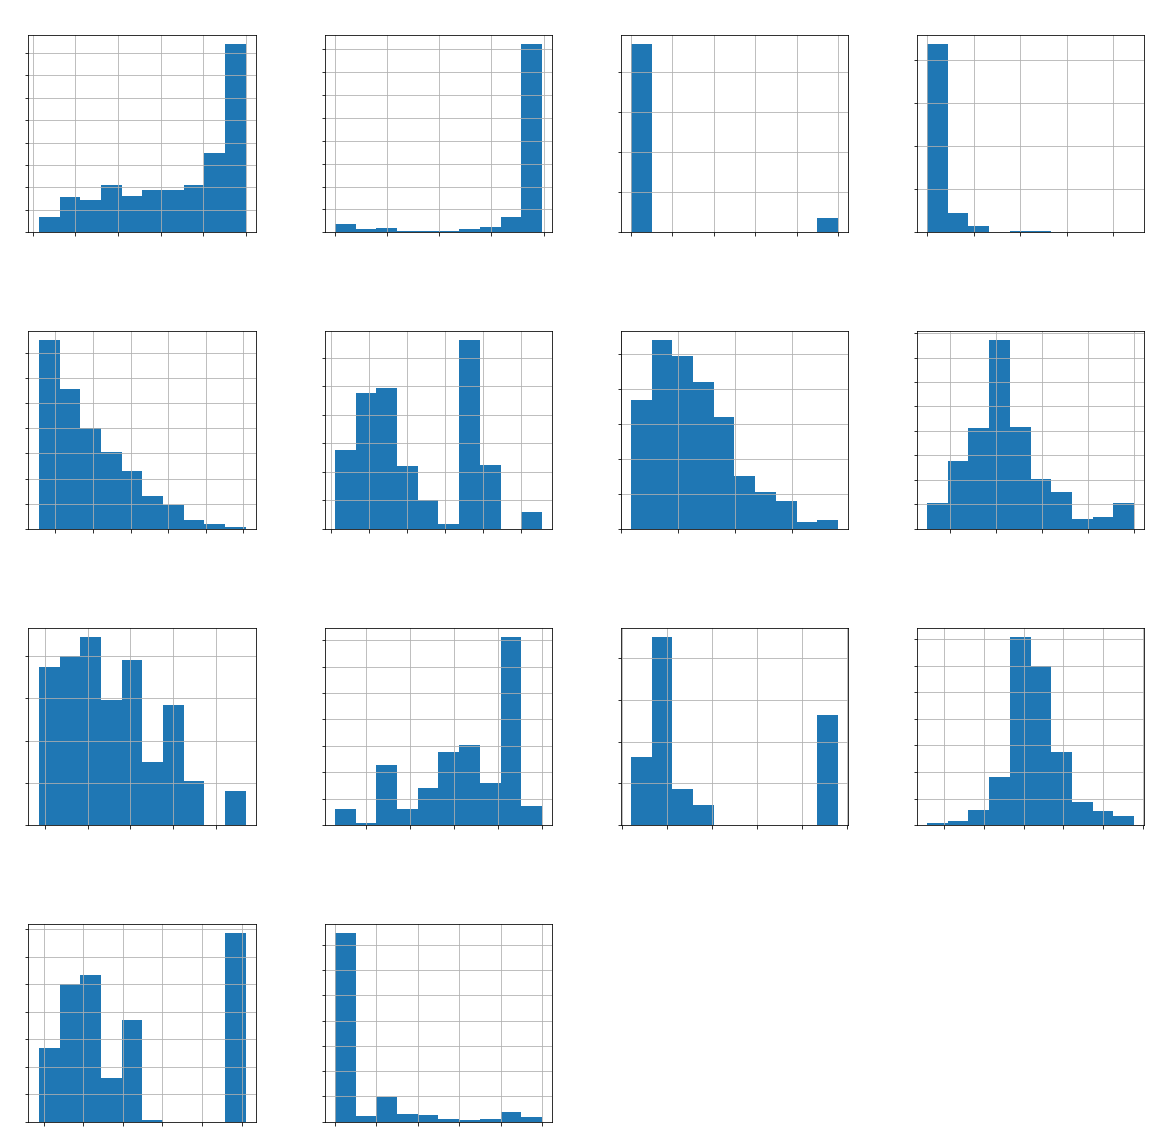

In [4]:
hist_matrix=dataset.hist(sharex=False,sharey=False,xlabelsize=30,ylabelsize=30,figsize=(20,20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
            wspace=None, hspace=0.5)
for hist_array in hist_matrix:
    for hist in  hist_array:
        hist.set_title(hist.get_title(),fontdict={"color":"white","fontsize":30})
        hist.tick_params(labelsize=10,labelcolor="white")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  i

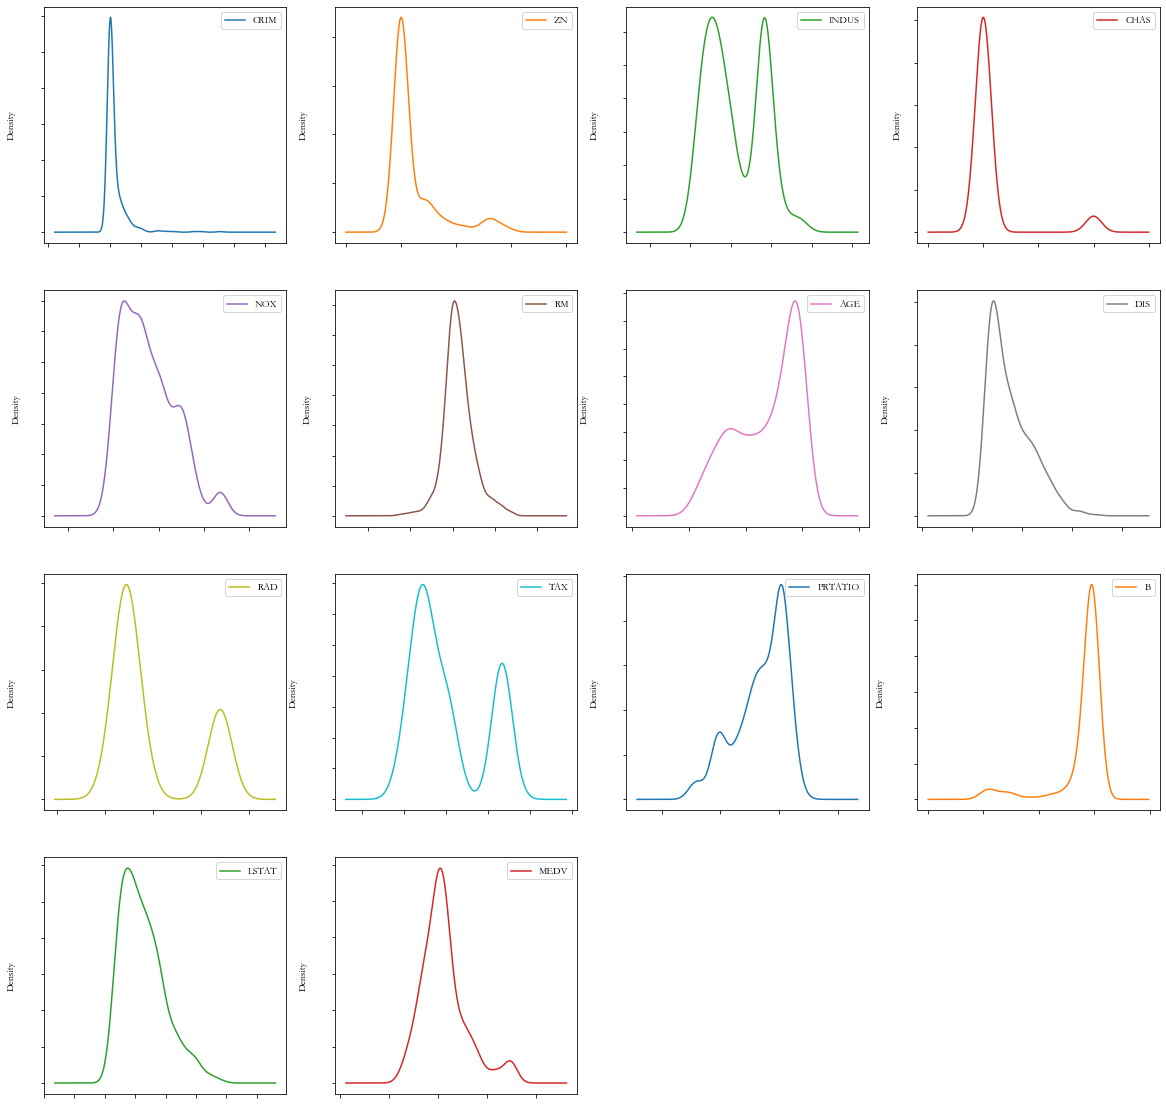

In [5]:
hist_matrix_plot=dataset.plot(kind = 'density', subplots = True, layout = (4,4),sharex = False, fontsize =1,figsize=(20,20))
for hist_array in hist_matrix_plot:
    for hist in  hist_array:
        hist.set_title(hist.get_title(),fontdict={"color":"white","fontsize":30})
        hist.tick_params(labelsize=10,labelcolor="white")

In [6]:
# 分离数据集

array = dataset.to_numpy()
X = array[:, 0:13]
Y = array[:, 13]
#data frame 与numpy 数据集一致 比较第一行
array[:1],dataset.head(1)

(array([[  0.02731,   0.     ,   7.07   ,   0.     ,   0.469  ,   6.421  ,
          78.9    ,   4.9671 ,   2.     , 242.     ,  17.8    , 396.9    ,
           9.14   ,  21.6    ]]),
    CRIM   ZN  INDUS  CHAS   NOX    RM   AGE   DIS  RAD  TAX  PRTATIO      B  \
 0  0.03  0.0   7.07     0  0.47  6.42  78.9  4.97    2  242     17.8  396.9   
 
    LSTAT  MEDV  
 0   9.14  21.6  )

In [7]:
# 与skilearn 中的默认数据集一致
boston_horse=datasets.load_boston()
X[0],boston_horse.data[1]

(array([  0.02731,   0.     ,   7.07   ,   0.     ,   0.469  ,   6.421  ,
         78.9    ,   4.9671 ,   2.     , 242.     ,  17.8    , 396.9    ,
          9.14   ]),
 array([  0.02731,   0.     ,   7.07   ,   0.     ,   0.469  ,   6.421  ,
         78.9    ,   4.9671 ,   2.     , 242.     ,  17.8    , 396.9    ,
          9.14   ]))

In [8]:
#验证X为数据集的前13列，Y为最后一列
X[0].reshape((len(X[0]),1)),array[0,].reshape((len(array[0,]),1)),Y[0,]

(array([[  0.02731],
        [  0.     ],
        [  7.07   ],
        [  0.     ],
        [  0.469  ],
        [  6.421  ],
        [ 78.9    ],
        [  4.9671 ],
        [  2.     ],
        [242.     ],
        [ 17.8    ],
        [396.9    ],
        [  9.14   ]]),
 array([[  0.02731],
        [  0.     ],
        [  7.07   ],
        [  0.     ],
        [  0.469  ],
        [  6.421  ],
        [ 78.9    ],
        [  4.9671 ],
        [  2.     ],
        [242.     ],
        [ 17.8    ],
        [396.9    ],
        [  9.14   ],
        [ 21.6    ]]),
 21.6)

In [9]:
validation_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state= seed)

In [10]:
#10折交叉验证
num_folds = 10
scoring = 'neg_mean_squared_error'




In [11]:
models = {
'LR':LinearRegression(),
'LASSO':Lasso(),
'EN':ElasticNet(),
'KNN':KNeighborsRegressor(),
'CART':DecisionTreeRegressor(),
'SVM':SVR()
}

models

{'LR': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'LASSO': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=None,
       selection='cyclic', tol=0.0001, warm_start=False),
 'EN': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 'KNN': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'),
 'CART': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples

In [12]:
# 评估算法

results = []
for key in models:
    kfold = KFold(n_splits=num_folds,random_state=seed)
    cv_result = cross_val_score(models["LR"],X_train,Y_train,cv = kfold,scoring=scoring)
    results.append(cv_result)
    print('%s: mean:%f,std:%f'%(key,cv_result.mean(),cv_result.std()))


LR: mean:-21.548069,std:7.253801
LASSO: mean:-21.548069,std:7.253801
EN: mean:-21.548069,std:7.253801
KNN: mean:-21.548069,std:7.253801
CART: mean:-21.548069,std:7.253801
SVM: mean:-21.548069,std:7.253801


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7

[Text(0, 0, 'LR'),
 Text(0, 0, 'LASSO'),
 Text(0, 0, 'EN'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'CART'),
 Text(0, 0, 'SVM')]

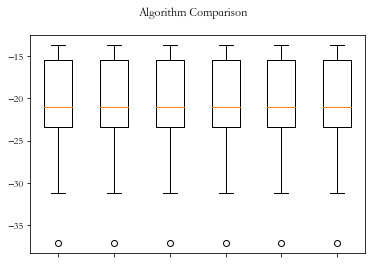

In [13]:
# 评估算法 —— 箱线图
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(models.keys(),fontdict={"color":"white","fontsize":10})


In [14]:
dt_regressor=DecisionTreeRegressor(max_depth=4)
dt_regressor.fit(X_train,Y_train)
Y_test_pred_dt=dt_regressor.predict(X_test)
output_metrics(Y_test,Y_test_pred_dt)

平均绝对误差 Mean absolute error= 3.27
均方误差(最低） Mean squared error= 26.12
中位数绝对误差 Median absolute error= 2.43
解释方差分(最高 1.0) explained variance score= 0.68
R方得分（最高1.0，可能为负) R2 score 0.68


In [15]:
ab_regrssor=AdaBoostRegressor(dt_regressor,n_estimators=400,random_state=7)
ab_regrssor.fit(X_train,Y_train)
Y_test_pred_ab=ab_regrssor.predict(X_test)
output_metrics(Y_test,Y_test_pred_ab)


平均绝对误差 Mean absolute error= 2.88
均方误差(最低） Mean squared error= 23.97
中位数绝对误差 Median absolute error= 1.93
解释方差分(最高 1.0) explained variance score= 0.71
R方得分（最高1.0，可能为负) R2 score 0.71


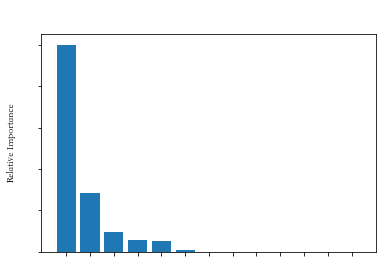

In [16]:
plot_feature_importance(dt_regressor.feature_importances_,'Decision Tree ',names)

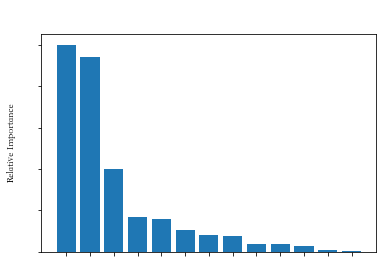

In [17]:
plot_feature_importance(ab_regrssor.feature_importances_,"Ada Boost",names)